In [ ]:
# Name : Sanjay V
# Reg No : 212223230188

In [7]:
pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 8.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled pro

(-0.5, 412.5, 530.5, -0.5)

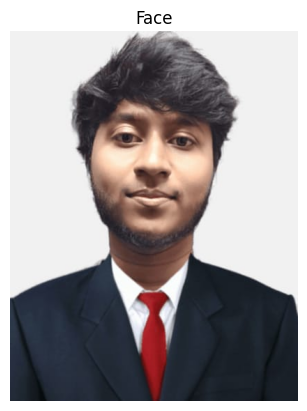

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load face image
faceImage = cv2.imread('san.jpg')
plt.imshow(faceImage[:,:,::-1])
plt.title("Face")
plt.axis('off')



Image shape: (233, 673, 4)


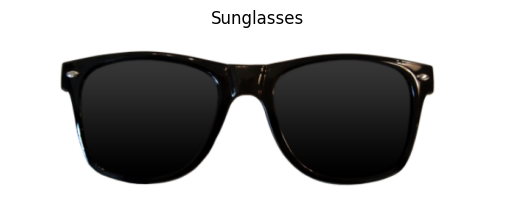

In [14]:
# Load sunglasses PNG (with transparency if available)
glassPNG = cv2.imread("sunn.png", cv2.IMREAD_UNCHANGED)
print("Image shape:", glassPNG.shape)

# Separate BGR and Alpha mask
if glassPNG.shape[2] == 4:
    glassBGR = glassPNG[:, :, :3]
    glassMask1 = glassPNG[:, :, 3]
else:
    glassBGR = glassPNG
    glassMask1 = 255 * np.ones(glassPNG.shape[:2], dtype=np.uint8)

plt.imshow(cv2.cvtColor(glassBGR, cv2.COLOR_BGR2RGB))
plt.title("Sunglasses")
plt.axis('off')
plt.show()


(-0.5, 672.5, 232.5, -0.5)

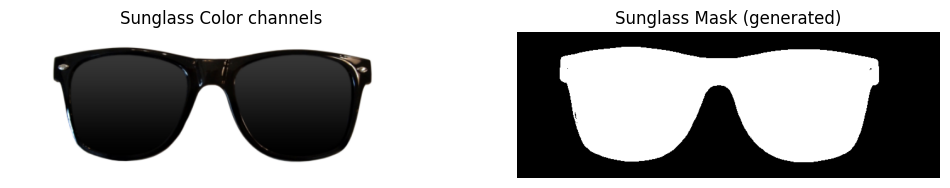

In [15]:
plt.figure(figsize=[12,5])

plt.subplot(1,2,1)
plt.imshow(glassBGR[:,:,::-1])
plt.title('Sunglass Color channels')
plt.axis('off')

glassGray = cv2.cvtColor(glassBGR, cv2.COLOR_BGR2GRAY)
_, glassMask1 = cv2.threshold(glassGray, 240, 255, cv2.THRESH_BINARY_INV)

plt.subplot(1,2,2)
plt.imshow(glassMask1, cmap='gray')
plt.title('Sunglass Mask (generated)')
plt.axis('off')

In [16]:
import mediapipe as mp

mp_face = mp.solutions.face_mesh
face_mesh = mp_face.FaceMesh(static_image_mode=True, max_num_faces=1)

rgb_img = cv2.cvtColor(faceImage, cv2.COLOR_BGR2RGB)
results = face_mesh.process(rgb_img)

In [17]:
h, w, _ = faceImage.shape

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        left_eye = face_landmarks.landmark[33]
        right_eye = face_landmarks.landmark[263]

        x1, y1 = int(left_eye.x * w), int(left_eye.y * h)
        x2, y2 = int(right_eye.x * w), int(right_eye.y * h)

        eye_width = abs(x2 - x1)
        new_w = int(eye_width * 2.0)
        new_h = int(new_w * glassBGR.shape[0] / glassBGR.shape[1])

        glass_resized = cv2.resize(glassBGR, (new_w, new_h))
        mask_resized = cv2.resize(glassMask1, (new_w, new_h))

        x = x1 - int(new_w * 0.25)
        y = y1 - int(new_h * 0.4)

        if x < 0: x = 0
        if y < 0: y = 0
        if x + new_w > w: new_w = w - x
        if y + new_h > h: new_h = h - y

        roi = faceImage[y:y+new_h, x:x+new_w]
        mask_resized = mask_resized[:new_h, :new_w]
        glass_resized = glass_resized[:new_h, :new_w]

        mask_inv = cv2.bitwise_not(mask_resized)
        mask_resized = cv2.merge([mask_resized]*3)
        mask_inv = cv2.merge([mask_inv]*3)

        bg = cv2.bitwise_and(roi, mask_inv)
        fg = cv2.bitwise_and(glass_resized, mask_resized)
        combined = cv2.add(bg, fg)

        faceImage[y:y+new_h, x:x+new_w] = combined


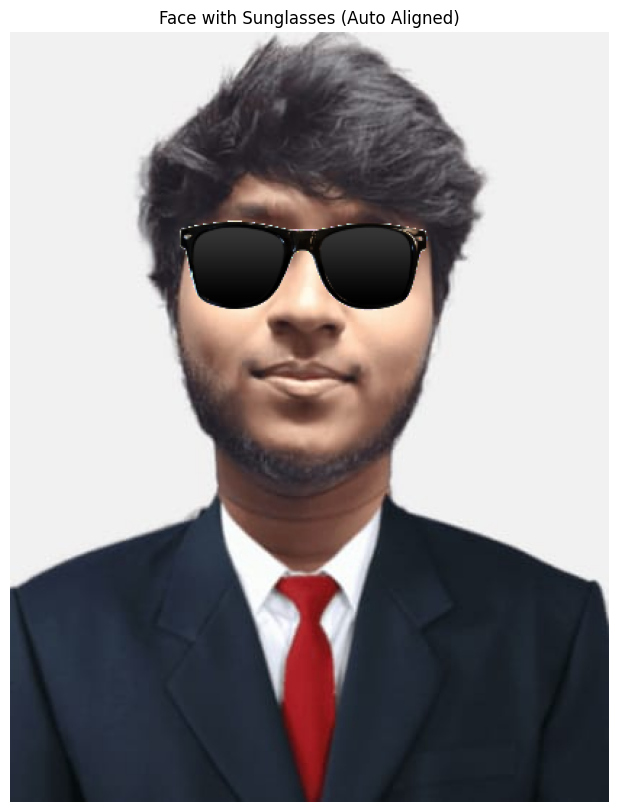

In [18]:

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(faceImage, cv2.COLOR_BGR2RGB))
plt.title("Face with Sunglasses (Auto Aligned)")
plt.axis("off")
plt.show()